In [7]:
!pip install transformers

In [8]:
!pip install transformers

In [16]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel
from torch.optim import AdamW  # استفاده از نسخه پایتورچ برای جلوگیری از ارور
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report
import time
import datetime

# تنظیمات اصلی
MAX_LEN = 128
BATCH_SIZE = 16
EPOCHS = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# لود کردن توکنایزر BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# نقشه تبدیل برچسب‌ها به عدد (Conflict را به Neutral وصل کردیم)
label_map = {'positive': 0, 'negative': 1, 'neutral': 2, 'conflict': 2}

In [17]:
class ABSADataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.text = dataframe.text.values
        self.aspect = dataframe.aspect.values
        self.targets = dataframe.sentiment.values
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        # ترکیب متن و جنبه برای BERT
        encoding = self.tokenizer(
            str(self.text[index]),
            str(self.aspect[index]),
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_token_type_ids=True,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'token_type_ids': encoding['token_type_ids'].flatten(),
            'targets': torch.tensor(label_map[self.targets[index]], dtype=torch.long)
        }

In [18]:
class BERT_ABSA_Classifier(nn.Module):
    def __init__(self, n_classes):
        super(BERT_ABSA_Classifier, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

    def forward(self, input_ids, attention_mask, token_type_ids):
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids
        )
        output = self.drop(outputs.pooler_output)
        return self.out(output)

model = BERT_ABSA_Classifier(n_classes=3).to(device)

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertModel LOAD REPORT from: bert-base-uncased
Key                                        | Status     |  | 
-------------------------------------------+------------+--+-
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED |  | 
cls.seq_relationship.bias                  | UNEXPECTED |  | 
cls.seq_relationship.weight                | UNEXPECTED |  | 
cls.predictions.transform.dense.bias       | UNEXPECTED |  | 
cls.predictions.transform.dense.weight     | UNEXPECTED |  | 
cls.predictions.bias                       | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


In [19]:
# بارگذاری فایل‌ها
train_df = pd.read_csv('train.csv')
val_df = pd.read_csv('validation.csv')
test_df = pd.read_csv('restuarnat_test.csv')

# ساخت لودرها
train_loader = DataLoader(ABSADataset(train_df, tokenizer, MAX_LEN), batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(ABSADataset(val_df, tokenizer, MAX_LEN), batch_size=BATCH_SIZE)
test_loader = DataLoader(ABSADataset(test_df, tokenizer, MAX_LEN), batch_size=BATCH_SIZE)

In [20]:
optimizer = AdamW(model.parameters(), lr=2e-5)
loss_fn = nn.CrossEntropyLoss().to(device)

def train_epoch(model, data_loader, loss_fn, optimizer, device, n_examples):
    model.train()
    losses, correct_predictions = [], 0
    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        token_type_ids = d["token_type_ids"].to(device)
        targets = d["targets"].to(device)

        outputs = model(input_ids, attention_mask, token_type_ids)
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)

        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        optimizer.zero_grad()
    return correct_predictions.double() / n_examples, sum(losses) / len(losses)

def evaluate_model(model, data_loader, device):
    model.eval()
    predictions, real_values = [], []
    with torch.no_grad():
        for d in data_loader:
            outputs = model(d["input_ids"].to(device), d["attention_mask"].to(device), d["token_type_ids"].to(device))
            _, preds = torch.max(outputs, dim=1)
            predictions.extend(preds.cpu().tolist())
            real_values.extend(d["targets"].cpu().tolist())
    return real_values, predictions

In [22]:
for epoch in range(EPOCHS):
    print(f'\n--- Epoch {epoch + 1} / {EPOCHS} ---')
    t0 = time.time()

    train_acc, train_loss = train_epoch(model, train_loader, loss_fn, optimizer, device, len(train_df))
    y_true_val, y_pred_val = evaluate_model(model, val_loader, device)
    val_acc = accuracy_score(y_true_val, y_pred_val)

    print(f'Time: {time.time()-t0:.2f}s | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}')


--- Epoch 1 / 5 ---
Time: 71.63s | Train Acc: 0.6750 | Val Acc: 0.7470

--- Epoch 2 / 5 ---
Time: 71.12s | Train Acc: 0.7830 | Val Acc: 0.7916

--- Epoch 3 / 5 ---
Time: 70.98s | Train Acc: 0.8680 | Val Acc: 0.7916

--- Epoch 4 / 5 ---
Time: 70.99s | Train Acc: 0.9198 | Val Acc: 0.7889

--- Epoch 5 / 5 ---
Time: 70.94s | Train Acc: 0.9496 | Val Acc: 0.8092



==================== Classification Report ====================
              precision    recall  f1-score   support

    positive       0.87      0.93      0.90       728
    negative       0.78      0.68      0.73       196
     neutral       0.62      0.54      0.58       210

    accuracy                           0.82      1134
   macro avg       0.76      0.72      0.73      1134
weighted avg       0.81      0.82      0.81      1134

👉 Final Macro-F1 Score: 0.7344


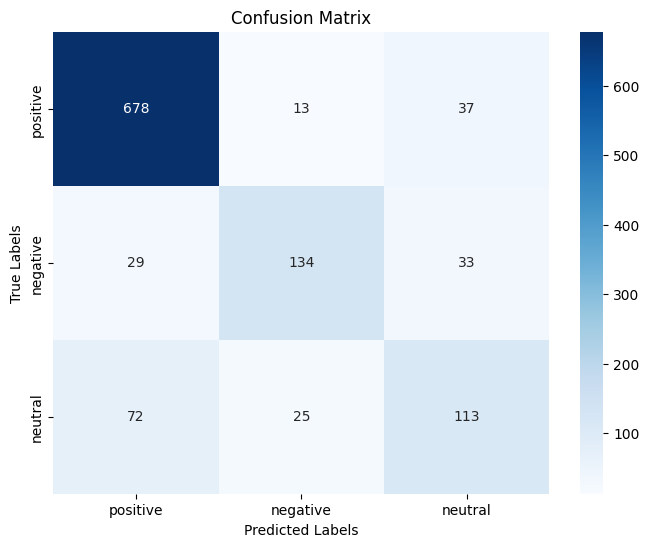


==================== Error Analysis (5 Samples) ====================

❌ Error #1
Sentence: Certainly not the best sushi in New York, however, it is always fresh, and the place is very clean, sterile.
Aspect: sushi
True Label: neutral
Predicted Label: positive

❌ Error #2
Sentence: Try the rose roll (not on menu).
Aspect: rose roll
True Label: positive
Predicted Label: neutral

❌ Error #3
Sentence: While there's a decent menu, it shouldn't take ten minutes to get your drinks and 45 for a dessert pizza.
Aspect: dessert pizza
True Label: neutral
Predicted Label: negative

❌ Error #4
Sentence: The sangria's - watered down.
Aspect: sangria
True Label: negative
Predicted Label: positive

❌ Error #5
Sentence: the two waitress's looked like they had been sucking on lemons.
Aspect: waitress's
True Label: negative
Predicted Label: neutral


In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, f1_score

def final_evaluation_report(model, data_loader, device, df_original):
    model.eval()
    all_preds = []
    all_targets = []
    all_texts = []
    all_aspects = []

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            token_type_ids = d["token_type_ids"].to(device)
            targets = d["targets"].to(device)

            outputs = model(input_ids, attention_mask, token_type_ids)
            _, preds = torch.max(outputs, dim=1)

            all_preds.extend(preds.cpu().tolist())
            all_targets.extend(targets.cpu().tolist())

    # نگاشت اعداد به کلمات برای گزارش نهایی
    target_names = ['positive', 'negative', 'neutral']

    # ۱. چاپ گزارش دسته‌بندی (Classification Report) - ۵ نمره
    print("\n" + "="*20 + " Classification Report " + "="*20)
    print(classification_report(all_targets, all_preds, target_names=target_names))

    # چاپ Macro-F1 به صورت جداگانه طبق خواسته پروژه
    macro_f1 = f1_score(all_targets, all_preds, average='macro')
    print(f"👉 Final Macro-F1 Score: {macro_f1:.4f}")

    # ۲. رسم ماتریس آشفتگی (Confusion Matrix) - ۵ نمره
    cm = confusion_matrix(all_targets, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=target_names, yticklabels=target_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

    # ۳. تحلیل خطا (Error Analysis) - ۵ نمره
    # پیدا کردن ۵ نمونه که مدل غلط پیش‌بینی کرده
    print("\n" + "="*20 + " Error Analysis (5 Samples) " + "="*20)
    errors = 0
    for i in range(len(all_targets)):
        if all_targets[i] != all_preds[i]:
            print(f"\n❌ Error #{errors + 1}")
            print(f"Sentence: {df_original.iloc[i]['text']}")
            print(f"Aspect: {df_original.iloc[i]['aspect']}")
            print(f"True Label: {target_names[all_targets[i]]}")
            print(f"Predicted Label: {target_names[all_preds[i]]}")
            errors += 1
        if errors == 5: break

# اجرای گزارش روی داده‌های تست
# نکته: test_df همان دیتایی است که اول لود کردیم
final_evaluation_report(model, test_loader, device, test_df)